In [140]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-forecasting-dataset/features.csv
/kaggle/input/retail-forecasting-dataset/stores.csv
/kaggle/input/retail-forecasting-dataset/train.csv
/kaggle/input/retail-forecasting-dataset/test.csv


In [141]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import shap
import warnings
warnings.filterwarnings('ignore')
print("Step 1: Libraries imported.")


Step 1: Libraries imported.


In [142]:
# Step 2: Load data
train = pd.read_csv("/kaggle/input/retail-forecasting-dataset/train.csv")
test = pd.read_csv("/kaggle/input/retail-forecasting-dataset/test.csv")
features = pd.read_csv("/kaggle/input/retail-forecasting-dataset/features.csv")
stores = pd.read_csv("/kaggle/input/retail-forecasting-dataset/stores.csv")
print("Step 2: Data loaded.")


Step 2: Data loaded.


In [143]:
# Step 3: Merge datasets
train = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
train = train.merge(stores, on='Store', how='left')
test = test.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
test = test.merge(stores, on='Store', how='left')
print("Step 3: Data merged.")


Step 3: Data merged.


In [144]:
# Step 4: Add date-based features
for df in [train, test]:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Day'] = df['Date'].dt.dayofweek
    df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
    df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
    df['WeekOfMonth'] = df['Date'].dt.day // 7 + 1
    df['IsWeekend'] = df['Day'].isin([5, 6]).astype(int)
print("Step 4: Date features added.")


Step 4: Date features added.


In [145]:
# Step 5: Create lag and rolling features
train = train.sort_values(['Store', 'Dept', 'Date'])
train['Lag_1'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
train['Lag_4'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)
train['Lag_52'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)

train['Rolling_4'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(4).mean())
train['Sales_Change'] = train['Lag_1'] - train['Lag_4']
train = train.dropna()
print("Step 5: Lag and rolling features created.")


Step 5: Lag and rolling features created.


In [146]:
# Step 6: Feature list
features_cols = [
    'Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size',
    'IsHoliday', 'Year', 'Month', 'Week', 'Day',
    'IsMonthStart', 'IsMonthEnd', 'WeekOfMonth', 'IsWeekend',
    'Lag_1', 'Lag_4', 'Lag_52', 'Rolling_4', 'Sales_Change'
]

X = train[features_cols]
y = train['Weekly_Sales']
print("Step 6: Features and target selected.")


Step 6: Features and target selected.


In [147]:
# Step 7: Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.2)
print("Step 7: Data split.")


Step 7: Data split.


In [148]:
# Step 8: Train model
model = xgb.XGBRegressor(n_estimators=100, max_depth=8, learning_rate=0.1, n_jobs=-1)
model.fit(X_train, y_train)
print("Step 8: Model trained.")


Step 8: Model trained.


In [149]:
# Step 9: Evaluate model
val_preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"Step 9: Model evaluated. Validation RMSE: {rmse:.2f}")


Step 9: Model evaluated. Validation RMSE: 2825.94


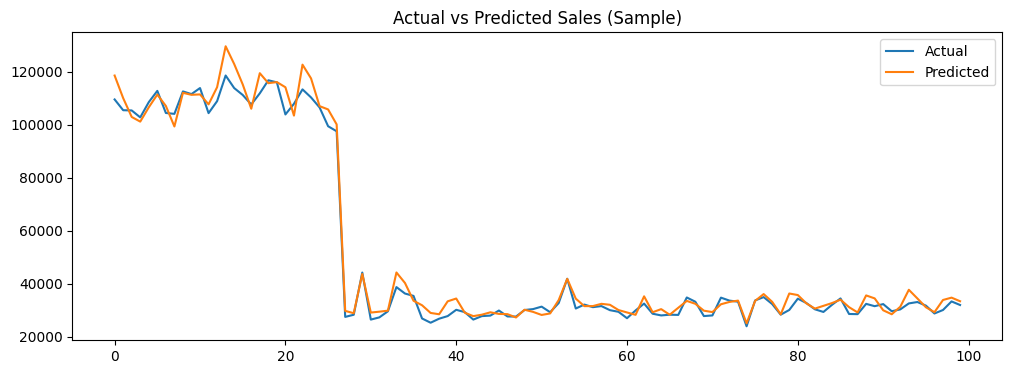

Step 10: Plot displayed.


In [150]:
# Step 10: Plot actual vs predicted
plt.figure(figsize=(12, 4))
plt.plot(y_val.values[:100], label="Actual")
plt.plot(val_preds[:100], label="Predicted")
plt.title("Actual vs Predicted Sales (Sample)")
plt.legend()
plt.show()
print("Step 10: Plot displayed.")


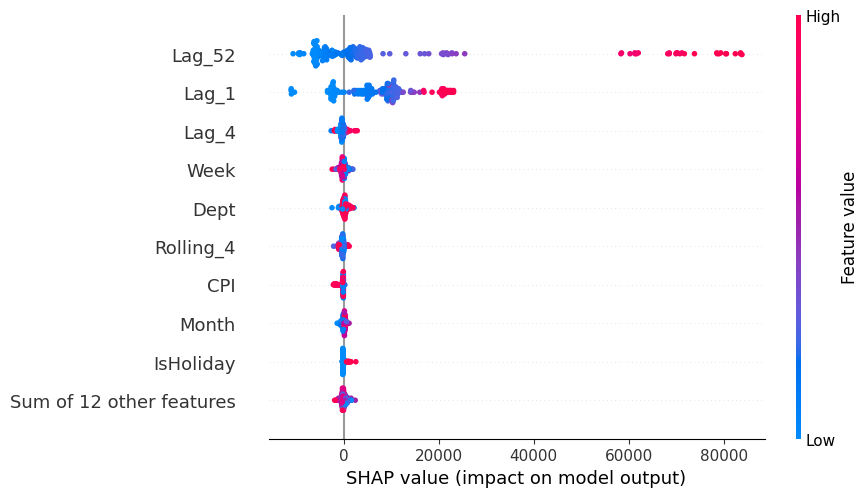

Step 11: SHAP analysis done.


In [151]:
# Step 11: SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X_val[:200])  # subset for speed
shap.plots.beeswarm(shap_values)
print("Step 11: SHAP analysis done.")


In [152]:
# Step 12: Adding rolling average features

# Sort
train = train.sort_values(['Store', 'Dept', 'Date'])
test = test.sort_values(['Store', 'Dept', 'Date'])

# Merge
train['source'] = 'train'
test['source'] = 'test'
test['Weekly_Sales'] = np.nan

combined = pd.concat([train, test], sort=False)

# Create rolling averages
combined['RollingAvg_4'] = combined.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(window=4).mean())
combined['RollingAvg_8'] = combined.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(window=8).mean())

# Split back
train = combined[combined['source'] == 'train'].drop(columns=['source'])
test = combined[combined['source'] == 'test'].drop(columns=['source'])

print("Step 12: Rolling averages added.")


Step 12: Rolling averages added.


📊 Plotting Weekly Sales vs Rolling Average...


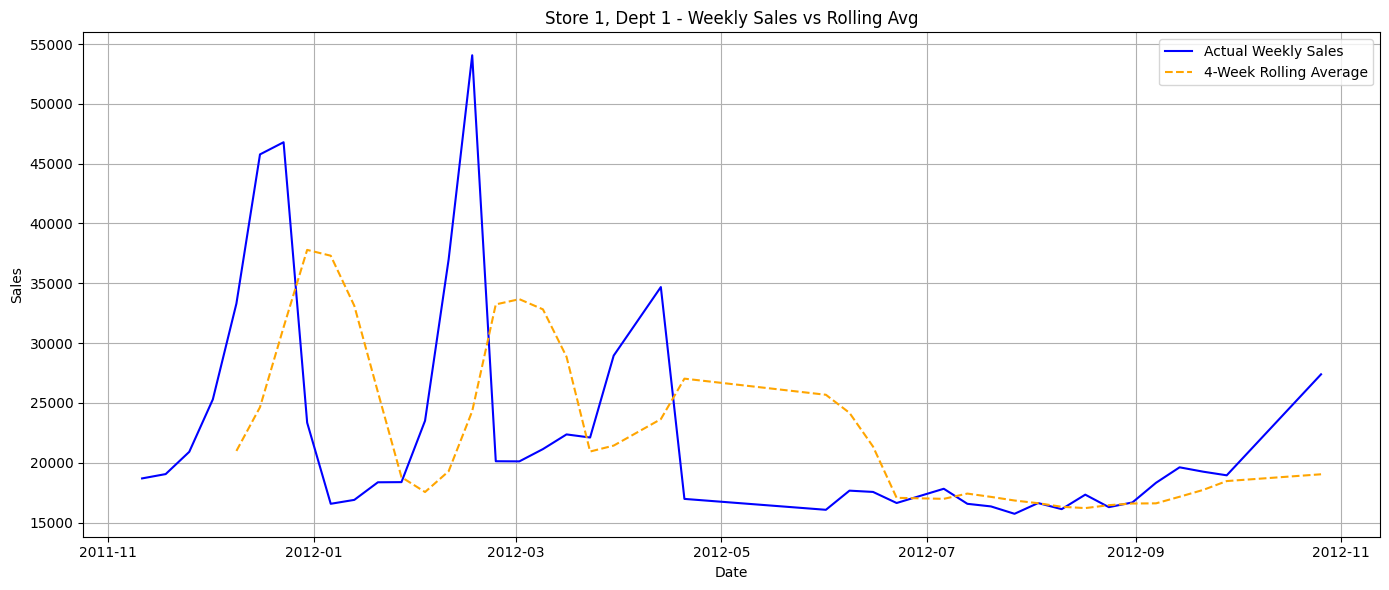

Step 13: Graph displayed for Store 1, Dept 1.


In [153]:
# Step 13 : Visualize Weekly Sales and Rolling Average
print("📊 Plotting Weekly Sales vs Rolling Average...")

import matplotlib.pyplot as plt

# Choose a specific Store and Dept to visualize (you can change this)
sample_store = 1
sample_dept = 1

# Filter the data
sample_data = train[(train['Store'] == sample_store) & (train['Dept'] == sample_dept)]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'], label='Actual Weekly Sales', color='blue')
plt.plot(sample_data['Date'], sample_data['RollingAvg_4'], label='4-Week Rolling Average', color='orange', linestyle='--')

plt.title(f"Store {sample_store}, Dept {sample_dept} - Weekly Sales vs Rolling Avg")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Step 13: Graph displayed for Store 1, Dept 1.")

✅ Predictions made.
📋 Sample Predictions:


,Store,Dept,Date,Weekly_Sales
0,1,1,2012-11-02,23478.4751
1,1,1,2012-11-09,21354.5376
2,1,1,2012-11-16,23796.3945
3,1,1,2012-11-23,25508.4464
4,1,1,2012-11-30,26699.3554
5,1,1,2012-12-07,22161.6996
6,1,1,2012-12-14,25910.7805
7,1,1,2012-12-21,24880.0928
8,1,1,2012-12-28,34238.7811
9,1,1,2013-01-04,31486.0927


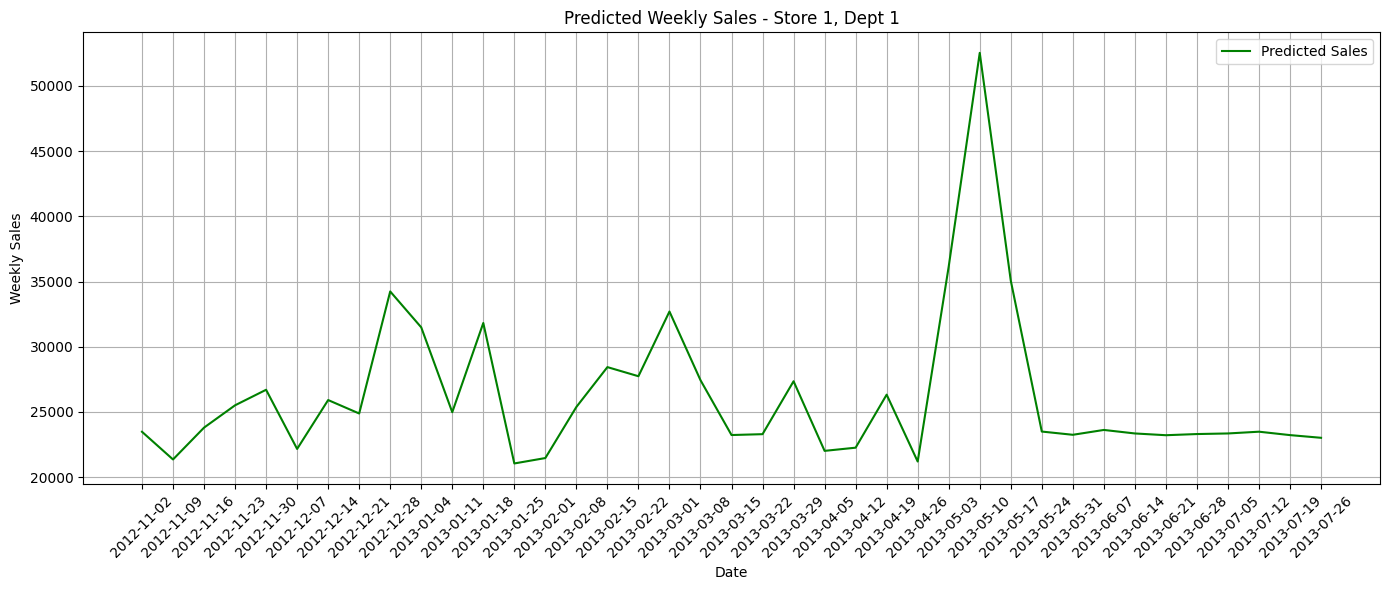

Step 14: Predictions saved to predicted_sales.csv


In [154]:
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/retail-forecasting-dataset/train.csv")
test = pd.read_csv("/kaggle/input/retail-forecasting-dataset/test.csv")
features = pd.read_csv("/kaggle/input/retail-forecasting-dataset/features.csv")
stores = pd.read_csv("/kaggle/input/retail-forecasting-dataset/stores.csv")


train = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
train = train.merge(stores, on='Store', how='left')
test = test.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
test = test.merge(stores, on='Store', how='left')

# 🧼 Preprocess: fill NA
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

# 🎯 Features and target
features_columns = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Type', 'Size']
X_train = pd.get_dummies(train[features_columns])
y_train = train['Weekly_Sales']
X_test = pd.get_dummies(test[features_columns])

# Align columns in case train/test differ
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# 🧠 Train model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 🧮 Make predictions
test['Weekly_Sales'] = model.predict(X_test)
print("✅ Predictions made.")

# 📋 Show predictions in tabular format
print("📋 Sample Predictions:")
display(test[['Store', 'Dept', 'Date', 'Weekly_Sales']].head(10))

# 📊 Plot predictions for one Store/Dept
sample_store = 1
sample_dept = 1

# Filter predictions
sample_test = test[(test['Store'] == sample_store) & (test['Dept'] == sample_dept)]
sample_test = sample_test.sort_values('Date')

# Plot
plt.figure(figsize=(14, 6))
plt.plot(sample_test['Date'], sample_test['Weekly_Sales'], label='Predicted Sales', color='green')
plt.title(f"Predicted Weekly Sales - Store {sample_store}, Dept {sample_dept}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 💾 Save predictions
test[['Store', 'Dept', 'Date', 'Weekly_Sales']].to_csv("predicted_sales.csv", index=False)
print("Step 14: Predictions saved to predicted_sales.csv")

In [155]:
# Step 15: Save results
submission = test[['Store', 'Dept', 'Date', 'Weekly_Sales']]
submission.to_csv ("sales_predictions.csv", index=False)
print("Step 15: Submission file saved as sales_predictions.csv")


Step 15: Submission file saved as sales_predictions.csv
